CLEAN AUDIT: Single Game Scenario
Testing winner and loser Q value learning

1. SETUP
--------------------------------------------------------------------------------
Agent created: DQN-Audit
Device: mps

2. CREATE BOARD POSITION
--------------------------------------------------------------------------------
Board after 5 moves:

. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
X X X . O O .
0 1 2 3 4 5 6

Current player: Player -1

3. PLAYER -1 MAKES LOSING MOVE
--------------------------------------------------------------------------------
Loser (Player -1) plays column 6
Loser state shape: (2, 6, 7)
Loser state from Player -1's perspective:
  Channel 0 (my pieces - O's): 2 pieces
  Channel 1 (opp pieces - X's): 3 pieces
After loser's move:
  Reward: 0.0 (from Player -1's perspective)
  Done: False
  Next state shape: (2, 6, 7)
  Next state from Player 1's perspective (flipped):
    Channel 0 (my pieces - X's): 3 pieces
    Channel 1 (opp pieces - O's): 3 piece

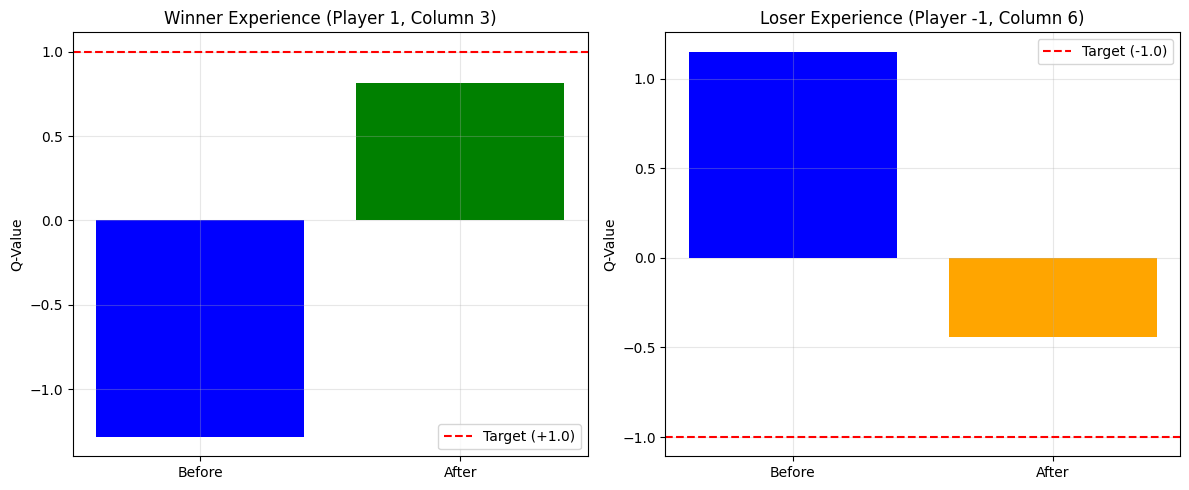

In [4]:
# ============================================================
# CLEAN AUDIT: Winner + Loser Experiences in Single Game
# ============================================================

import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

# Add project root to path
sys.path.append('..')

from src.environment.connect4 import ConnectFourEnvironment
from src.environment.config import Config
from src.agents.dqn_agent import DQNAgent
from src.networks.dqn_value_network import DQNValueNetwork

print("="*80)
print("CLEAN AUDIT: Single Game Scenario")
print("="*80)
print("Testing winner and loser Q value learning")
print()

# ============================================================
# 1. SETUP
# ============================================================

print("1. SETUP")
print("-" * 80)

# Create agent
agent = DQNAgent(
    name="DQN-Audit",
    player_id=1,
    conv_channels=[16, 32],
    fc_dims=[64],
    learning_rate=1e-4,
    gamma=0.99,
    batch_size=1,
    min_buffer_size=1,
    buffer_size=1000,
    target_update_freq=1000,
    use_double_dqn=True
)

print(f"Agent created: {agent.name}")
print(f"Device: {agent.device}")
print()

# Create environment
config = Config()
env = ConnectFourEnvironment(config)

# ============================================================
# 2. CREATE BOARD POSITION (One Move Before Win)
# ============================================================

print("2. CREATE BOARD POSITION")
print("-" * 80)

env.reset()
env.play_move(0)  # Player 1
env.play_move(4)  # Player -1
env.play_move(1)  # Player 1
env.play_move(5)  # Player -1
env.play_move(2)  # Player 1

print("Board after 5 moves:")
env.render()
print("Current player:", "Player 1" if env.current_player == 1 else "Player -1")
print()

# ============================================================
# 3. PLAYER -1 MAKES LOSING MOVE (Move 6)
# ============================================================

print("3. PLAYER -1 MAKES LOSING MOVE")
print("-" * 80)

# Get state BEFORE loser's move (from Player -1's perspective)
loser_state_before = env.get_state()
loser_action = 6  # Player -1 plays column 6 (doesn't block column 3)

print(f"Loser (Player -1) plays column {loser_action}")
print(f"Loser state shape: {loser_state_before.shape}")
print(f"Loser state from Player -1's perspective:")
print(f"  Channel 0 (my pieces - O's): {loser_state_before[0].sum():.0f} pieces")
print(f"  Channel 1 (opp pieces - X's): {loser_state_before[1].sum():.0f} pieces")

# Make loser's move
loser_next_state, loser_reward, loser_done = env.play_move(loser_action)

print(f"After loser's move:")
print(f"  Reward: {loser_reward} (from Player -1's perspective)")
print(f"  Done: {loser_done}")
print(f"  Next state shape: {loser_next_state.shape}")
print(f"  Next state from Player 1's perspective (flipped):")
print(f"    Channel 0 (my pieces - X's): {loser_next_state[0].sum():.0f} pieces")
print(f"    Channel 1 (opp pieces - O's): {loser_next_state[1].sum():.0f} pieces")

print("\nBoard after loser's move:")
env.render()
print()

# ============================================================
# 4. PLAYER 1 MAKES WINNING MOVE (Move 7)
# ============================================================

print("4. PLAYER 1 MAKES WINNING MOVE")
print("-" * 80)

# Get state BEFORE winner's move (from Player 1's perspective)
winner_state_before = env.get_state()
winner_action = 3  # Player 1 plays column 3 (wins!)

print(f"Winner (Player 1) plays column {winner_action}")
print(f"Winner state shape: {winner_state_before.shape}")
print(f"Winner state from Player 1's perspective:")
print(f"  Channel 0 (my pieces - X's): {winner_state_before[0].sum():.0f} pieces")
print(f"  Channel 1 (opp pieces - O's): {winner_state_before[1].sum():.0f} pieces")

# Make winner's move
winner_next_state, winner_reward, winner_done = env.play_move(winner_action)

print(f"After winner's move:")
print(f"  Reward: {winner_reward} (from Player 1's perspective)")
print(f"  Done: {winner_done}")
print(f"  Winner: Player {env.check_winner()}")

print("\nFinal board:")
env.render()
print()

# ============================================================
# 5. TEST WINNER EXPERIENCE
# ============================================================

print("5. TEST WINNER EXPERIENCE")
print("-" * 80)

# Get Q-value BEFORE training
q_winner_before = agent.get_q_values(winner_state_before)[winner_action]
print(f"Q-value before training: {q_winner_before:+.4f}")
print(f"Target: +1.0 (winning move)")

# Store winner experience
agent.observe(winner_state_before, winner_action, winner_reward, winner_next_state, winner_done)
print(f"Stored winner experience in replay buffer")

# Train 10 times
print(f"Training 10 iterations on winner experience...")
for i in range(10):
    metrics = agent.train(sample_indices=[-1])
    if i == 0 or i == 9:
        q_current = agent.get_q_values(winner_state_before)[winner_action]
        print(f"  Iteration {i+1}: Loss={metrics['loss']:.6f}, Q={q_current:+.4f}")

# Get Q-value AFTER training
q_winner_after = agent.get_q_values(winner_state_before)[winner_action]
print(f"\nQ-value after training: {q_winner_after:+.4f}")
print(f"Change: {q_winner_after - q_winner_before:+.4f}")

# Check if moved closer to target
dist_before = abs(q_winner_before - 1.0)
dist_after = abs(q_winner_after - 1.0)
winner_success = dist_after < dist_before

print(f"\nDistance from target (+1.0):")
print(f"  Before: {dist_before:.4f}")
print(f"  After:  {dist_after:.4f}")
print(f"  Result: {'✓ SUCCESS - Moved closer to +1.0' if winner_success else '✗ FAILURE - Moved away from +1.0'}")
print()

# ============================================================
# 6. TEST LOSER EXPERIENCE (Retroactive)
# ============================================================

print("6. TEST LOSER EXPERIENCE (Retroactive)")
print("-" * 80)

# Get Q-value BEFORE training
q_loser_before = agent.get_q_values(loser_state_before)[loser_action]
print(f"Q-value before training: {q_loser_before:+.4f}")
print(f"Target: -1.0 (losing move)")

# Store loser experience with retroactive -1.0 reward
agent.observe(loser_state_before, loser_action, -1.0, loser_next_state, True)
print(f"Stored loser experience with reward=-1.0 in replay buffer")

# Train 10 times
print(f"Training 10 iterations on loser experience...")
for i in range(10):
    metrics = agent.train(sample_indices=[-1])
    if i == 0 or i == 9:
        q_current = agent.get_q_values(loser_state_before)[loser_action]
        print(f"  Iteration {i+1}: Loss={metrics['loss']:.6f}, Q={q_current:+.4f}")

# Get Q-value AFTER training
q_loser_after = agent.get_q_values(loser_state_before)[loser_action]
print(f"\nQ-value after training: {q_loser_after:+.4f}")
print(f"Change: {q_loser_after - q_loser_before:+.4f}")

# Check if moved closer to target
dist_before = abs(q_loser_before - (-1.0))
dist_after = abs(q_loser_after - (-1.0))
loser_success = dist_after < dist_before

print(f"\nDistance from target (-1.0):")
print(f"  Before: {dist_before:.4f}")
print(f"  After:  {dist_after:.4f}")
print(f"  Result: {'✓ SUCCESS - Moved closer to -1.0' if loser_success else '✗ FAILURE - Moved away from -1.0'}")
print()

# ============================================================
# 7. FINAL RESULTS
# ============================================================

print("="*80)
print("FINAL RESULTS")
print("="*80)

print(f"\nWinner Experience (Player 1, column {winner_action}):")
print(f"  Q-value: {q_winner_before:+.4f} → {q_winner_after:+.4f}")
print(f"  Target: +1.0")
print(f"  Status: {'✓ PASS' if winner_success else '✗ FAIL'}")

print(f"\nLoser Experience (Player -1, column {loser_action}):")
print(f"  Q-value: {q_loser_before:+.4f} → {q_loser_after:+.4f}")
print(f"  Target: -1.0")
print(f"  Status: {'✓ PASS' if loser_success else '✗ FAIL'}")

print(f"\nOverall: {'✓✓ BOTH TESTS PASSED' if winner_success and loser_success else '✗✗ ONE OR MORE TESTS FAILED'}")
print("="*80)

# ============================================================
# 8. VISUALIZATION
# ============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Winner Q-value
ax1.bar(['Before', 'After'], [q_winner_before, q_winner_after], color=['blue', 'green'])
ax1.axhline(y=1.0, color='r', linestyle='--', label='Target (+1.0)')
ax1.set_ylabel('Q-Value')
ax1.set_title('Winner Experience (Player 1, Column 3)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loser Q-value
ax2.bar(['Before', 'After'], [q_loser_before, q_loser_after], color=['blue', 'orange'])
ax2.axhline(y=-1.0, color='r', linestyle='--', label='Target (-1.0)')
ax2.set_ylabel('Q-Value')
ax2.set_title('Loser Experience (Player -1, Column 6)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
